In [4]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.mc_sfs import *
from cfollmer.drifts import SimpleForwardNet, SimpleForwardNetBN, ResNetScoreNetwork
from cfollmer.sampler_utils import FollmerSDE

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
class DNN(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(DNN, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_dim)
        )
        
    def forward(self, x):
        return self.nn(x)

    
class LinModel(torch.nn.Module):
    
    def __init__(self, input_dim=1, output_dim=1):
        super(LinModel, self).__init__()
        
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 1),
        )
        
    def forward(self, x):
        return self.nn(x)

In [7]:
def train(X_train, y_train, gamma, dim, n_steps, data_batch_size, param_batch_size, dt=0.05, stl=False, size_list=None):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []

    for _ in tqdm(range(n_steps)):
        perm = torch.randperm(N_train)
        x = X_train[perm[:data_batch_size], :]
        y = y_train[perm[:data_batch_size], :]

        optimizer.zero_grad()
        
        partial_log_p = lambda params_batch: log_posterior_batch(x, y, params_batch, size_list=size_list)
#         import pdb; pdb.set_trace()
        loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        
        if stl: # double check theres no references left
            sde.drift_network_detatched.load_state_dict((sde.drift_network.state_dict()))
    
    losses = np.array(losses)
    
    return sde, losses

In [8]:



def predict(param_samples, x, y, size_list=None):
    with torch.no_grad():
        predict_func = lambda params : func_model(functional.get_params_from_array(params, size_list), x)
        predict_func = functorch.vmap(predict_func)

        preds = predict_func(param_samples)

        std, mean = torch.std_mean(preds, dim=0)
        mse = torch.mean((y_test - mean)**2)
        logp = torch.mean(log_likelihood_batch(x, y, param_samples, size_list=size_list))
        
    return std, mean, logp, mse


sigma2 = 1
sigma_n = 0.2



In [9]:
def pred_true_std(X_train, X_test, sigma_n, sigma2, dim):
    # https://github.com/probml/pml-book/releases/latest/download/book1.pdf
    # See Eq 11.124 in the above link page 430 on pdf viewer (page 400 on page number in pdf)

    X_trainnp = X_train.cpu().detach().numpy()
    n_, d = X_trainnp.shape

    X_trainnp = np.concatenate((X_trainnp, np.ones((n_, 1))), axis=1)

    X_testnp = X_test.cpu().detach().numpy()
    n_, d = X_testnp.shape

    X_testnp = np.concatenate((X_testnp, np.ones((n_, 1))), axis=1)


    Sigma_post = sigma_n**2 * np.linalg.inv(sigma_n**2 *  np.eye(dim) / sigma2 + np.dot(X_trainnp.T,X_trainnp))
    
    sigma_pred = []
    for i in range(n_):
        sigma_pred += [np.dot(X_testnp[i,:].dot(Sigma_post), X_testnp[i,:]) + sigma_n**2 ]

    std_true = np.sqrt(sigma_pred)
    return std_true


def pred_true_mean(y_train, X_train, X_test, sigma_n, sigma2, dim):
    # https://github.com/probml/pml-book/releases/latest/download/book1.pdf
    # See Eq 11.124 in the above link page 430 on pdf viewer (page 400 on page number in pdf)

    X_trainnp = X_train.cpu().detach().numpy()
    n_, d = X_trainnp.shape
    
    lambda_ = sigma_n**2 / sigma2 

    X_trainnp = np.concatenate((X_trainnp, np.ones((n_, 1))), axis=1)

    X_testnp = X_test.cpu().detach().numpy()
    n_, d = X_testnp.shape

    X_testnp = np.concatenate((X_testnp, np.ones((n_, 1))), axis=1)

    Xty = np.dot(X_trainnp.T, y_train)

    Sigma_post = np.linalg.inv(sigma_n**2 *  np.eye(dim) / sigma2 + np.dot(X_trainnp.T,X_trainnp))
    
    w = np.dot(Sigma_post, Xty)
    
    return np.dot(X_testnp,w)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"



def lin_reg_data_gen(dim, sigma_n, device, num_samps=30):

    w = np.ones((dim,1))
    b = 1

    func = lambda x: np.dot(x, w)  + 1.0

    # Test inputs
    num_test_samples = 30

    if dim == 1:
        X_test = np.linspace(-16, 16, num_samps).reshape(num_samps,1)
        X_train = np.linspace(-3.5, 3.5, num_samps).reshape(-1,1)
    else:
        X_test  = np.random.randn(num_samps, dim)
        X_train  = np.random.randn(num_samps, dim)

    # Noise free training inputs

    #f_train = np.cos(X_train) 
    f_train = func(X_train)

    # Noise-free training outputs
    #f = np.cos(X_test)
    f = func(X_test)
    y_test  = f

    # Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)

    mu = np.zeros(X_train.shape[0])
    
#     import pdb; pdb.set_trace()
    epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.shape[0]))

    # Noisy targets
    try:
        y_train = f_train + epsilon.reshape(X_train.shape[0],1)
    except:
        import pdb; pdb.set_trace()
    
    return X_train, y_train, X_test, y_test, f


gamma = 0.1**2

n_steps = 300
data_batch_size = 50
param_batch_size = 32
samps_lost = []

errors = []

samp_no = 100


def log_prior(params):
    return -torch.sum(params**2) / (2 * sigma2)

def log_likelihood(x, y, params, size_list=None):
#     import pdb; pdb.set_trace()

    preds = func_model(functional.get_params_from_array(params, size_list), x)
    
    diff = preds - y
    
    return - torch.sum(diff**2) / (2 * sigma_n**2)

def log_likelihood_batch(x, y, params_batch, size_list=None):
    func = lambda params: log_likelihood(x, y, params, size_list=size_list)
    func = functorch.vmap(func)
    return func(params_batch)

def log_posterior(x, y, params, size_list=None):
    return log_prior(params) + (N_train / x.shape[0]) * log_likelihood(x, y, params, size_list=size_list)

def log_posterior_batch(x, y, params_batch, size_list=None):
    func = lambda params: log_posterior(x, y, params, size_list=size_list)
    func = functorch.vmap(func)
    return func(params_batch)


start, end = 0, 12
dt=0.01
for i in range(start,end):
    dim = dim_data =  2**i


    X_train, y_train, X_test, y_test, f = lin_reg_data_gen(dim,  sigma_n, device)
    print(X_train.shape)

    N_train , _ = X_train.shape
    N_test , _ = X_test.shape
    
    X_train = torch.tensor(X_train, device=device, dtype=torch.float)
    X_test = torch.tensor(X_test, device=device, dtype=torch.float)

    y_train = torch.tensor(y_train, device=device, dtype=torch.float)
    y_test = torch.tensor(y_test, device=device, dtype=torch.float)
    
    ################################  N-SFS #########################################################
    model = LinModel(input_dim=dim).to(device)
    func_model, params = functorch.make_functional(model)
    size_list = functional.params_to_size_tuples(params)
    dim_mod = functional.get_number_of_params(size_list)
#     print(size_list)
#     
#     import pdb; pdb.set_trace()
    
    sde, losses = train(X_train, y_train, gamma, dim_mod, n_steps, data_batch_size, param_batch_size, size_list=size_list)
    param_samples = sde.sample(samp_no, dt=dt, device=device)
    std, mean, logp, mse = predict(param_samples, X_test, y_test, size_list=size_list)
    std = torch.sqrt(std**2 + sigma_n**2)
    
    ################################  SFS ############################################################
    sde_sfs = MCFollmerSDE(torch.tensor(gamma), dim_mod, log_posterior, X_train, y_train, device, size_list=size_list)
    sfs_samps = sde_sfs.sample(samp_no, dt=dt, device=device)
    sfs_samps = sfs_samps[~torch.isnan(sfs_samps).sum(dim=1).bool()]
    std_sfs, mean_sfs, logp_sfs, mse_sfs = predict(sfs_samps, X_test, y_test, size_list=size_list)
    std_sfs = torch.sqrt(std_sfs**2 + sigma_n**2)
    
    samps_lost.append(((torch.isnan(sfs_samps).sum(dim=1).bool()).sum(), samp_no) )
    
    
    ################################  True ############################################################
    std_true = pred_true_std(X_train, X_test, sigma_n,  sigma2, dim_mod)
    mean_true = pred_true_mean(y_train.detach().cpu(), X_train, X_test, sigma_n,  sigma2, dim_mod)
    
    
    ################################  Errors ############################################################
    
    mae =  lambda x,y: torch.abs(torch.tensor(x).to(device)-torch.tensor(y).to(device)).sum(dim=-1).mean()
    mse =  lambda x,y: torch.sqrt(((torch.tensor(x).to(device)-torch.tensor(y).to(device) )**2).sum(dim=-1).mean())
    
    errors.append(
        {
            "mae_sfs_mean": mae(mean_sfs, mean_true),
            "mae_nsfs_mean": mae(mean, mean_true),
            "mse_sfs_mean": mse(mean_sfs, mean_true),
            "mse_nsfs_mean": mse(mean, mean_true),
            "mae_sfs_std": mae(std_sfs, std_true),
            "mae_nsfs_std": mae(std, std_true),
            "mse_sfs_std": mse(std_sfs, std_true),
            "mse_nsfs_std": mse(std, std_true),
        }
    )
#     del func_model

(30, 1)


  0%|          | 0/300 [00:00<?, ?it/s]/home/fav25/.conda/envs/functorch/lib/python3.9/site-packages/torch/nn/functional.py:2282: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
100%|██████████| 300/300 [00:15<00:00, 19.39it/s]
/home/fav25/ControlledFollmerDrift/cfollmer/mc_sfs.py:54: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::__or__.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-jk216yxu/functorch/csrc/BatchedFallback.cpp:106.)
  isnan = torch.isinf(torch.abs(out)) | torch.isnan(out)
/home/fav25/ControlledFollmerDrift/cfollmer/mc_sfs.py:100: UserWarning: There is a performa

(30, 2)


100%|██████████| 300/300 [00:16<00:00, 18.67it/s]


(30, 4)


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


(30, 8)


100%|██████████| 300/300 [00:16<00:00, 18.02it/s]


(30, 16)


100%|██████████| 300/300 [00:16<00:00, 17.86it/s]


(30, 32)


100%|██████████| 300/300 [00:16<00:00, 17.99it/s]


(30, 64)


100%|██████████| 300/300 [00:17<00:00, 17.36it/s]


(30, 128)


100%|██████████| 300/300 [00:16<00:00, 18.63it/s]


(30, 256)


100%|██████████| 300/300 [00:15<00:00, 19.78it/s]


(30, 512)


100%|██████████| 300/300 [00:16<00:00, 18.57it/s]


(30, 1024)


100%|██████████| 300/300 [00:19<00:00, 15.67it/s]


(30, 2048)


100%|██████████| 300/300 [00:17<00:00, 17.44it/s]


In [11]:
x_ax  = [2**x for x in range(start, end)]

mae_sfs_mean = [x["mae_sfs_mean"].item() for x in errors]
mae_nsfs_mean = [x["mae_nsfs_mean"].item() for x in errors]

mae_sfs_std = [x["mae_sfs_std"].item() for x in errors]
mae_nsfs_std = [x["mae_nsfs_std"].item() for x in errors]

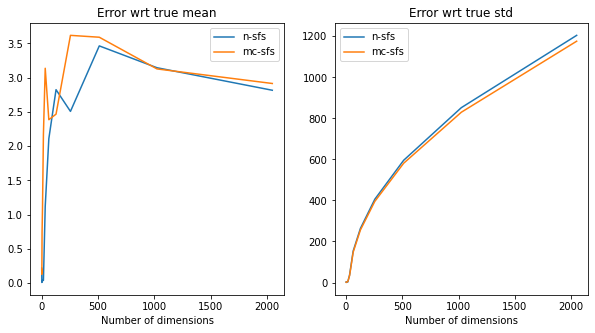

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))


ax1.plot(x_ax, mae_nsfs_mean, label="n-sfs")
ax1.plot(x_ax, mae_sfs_mean, label="mc-sfs")

ax1.set_xlabel("Number of dimensions")

ax1.set_title("Error wrt true mean")
ax1.legend()


ax2.plot(x_ax ,mae_nsfs_std, label="n-sfs")
ax2.plot(x_ax, mae_sfs_std, label="mc-sfs")
ax2.set_xlabel("Number of dimensions")
ax2.set_title("Error wrt true std")
ax2.legend()

In [2]:
samps_lost

NameError: name 'samps_lost' is not defined

In [3]:
(torch.isnan(sfs_samps).sum(dim=1).bool()).sum()

NameError: name 'torch' is not defined